# Data Preprocessing/Visualization

Keys inside the file: ['image', 'mask']
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)


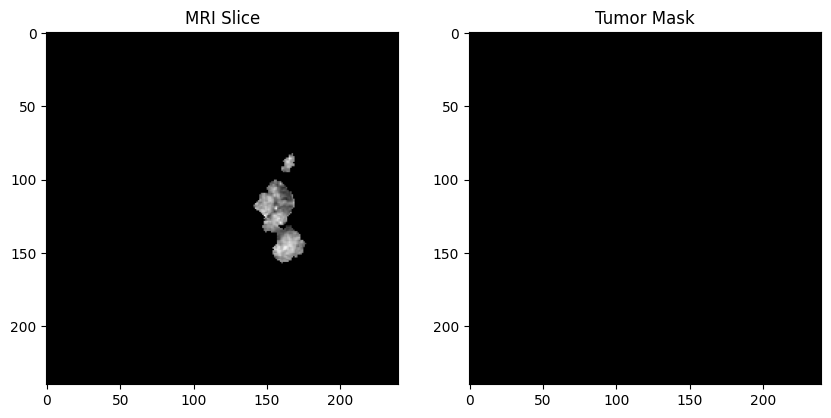

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# UPDATE THIS to the path of one of your files
test_file_path = "C:\\Users\\shara\\.cache\\kagglehub\\datasets\\awsaf49\\brats2020-training-data\\versions\\3\\BraTS2020_training_data\\content\\data\\volume_1_slice_12.h5" 

if os.path.exists(test_file_path):
    with h5py.File(test_file_path, 'r') as f:
        print("Keys inside the file:", list(f.keys()))
        
        # Let's assume the keys are 'image' and 'mask' (common in this dataset)
        # If the print statement above shows different names, update them below!
        img = f['image'][:]
        mask = f['mask'][:]
        
        print(f"Image shape: {img.shape}")
        print(f"Mask shape: {mask.shape}")

        # Visualize
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img[:,:,2], cmap='gray') # Showing 3rd channel (usually T2 or FLAIR)
        plt.title("MRI Slice")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Tumor Mask")
        plt.show()
else:
    print("File not found. Check your path.")

# 2.5D Segmentation Data Loaders

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_DIR = "C:\\Users\\shara\\.cache\\kagglehub\\datasets\\awsaf49\\brats2020-training-data\\versions\\3\\BraTS2020_training_data\\content\\data"
META_FILE = "C:\\Users\\shara\\.cache\\kagglehub\\datasets\\awsaf49\\brats2020-training-data\\versions\\3\\BraTS2020_training_data\\content\\data\\meta_data.csv"

df = pd.read_csv(META_FILE)

df['filename'] = df['slice_path'].apply(lambda x: os.path.basename(x)) # Get just "volume_41_slice_0.h5"
df['local_path'] = df['filename'].apply(lambda x: os.path.join(DATA_DIR, x))

unique_patients = df['volume'].unique()[:100]  # Limit to first 100 patients for quick testing
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_df = df[df['volume'].isin(train_ids)]
val_df = df[df['volume'].isin(val_ids)]

# train_df = train_df[train_df['target'] == 1] 

print(f"Total {len(unique_patients)}")
print(f"Training {len(train_df)} (from {len(train_ids)} patients)")
print(f"Validation {len(val_df)} (from {len(val_ids)} patients)")

Total 100
Training 12400 (from 80 patients)
Validation 3100 (from 20 patients)


# Group Classification (Patient Based)

In [5]:
## UNET

In [6]:
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, ScaleIntensity, EnsureType

class BraTS2DDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get path from DataFrame
        file_path = self.dataframe.iloc[idx]['local_path']
        
        with h5py.File(file_path, 'r') as f:
            img = f['image'][:] 
            mask = f['mask'][:]

        # Fix Image Dimensions: (H, W, C) -> (C, H, W)
        if img.shape[-1] == 4:
            img = np.transpose(img, (2, 0, 1))
            
        # BraTS Label Mapping (Same as before)
        wt = np.logical_or(mask == 1, np.logical_or(mask == 2, mask == 4))
        tc = np.logical_or(mask == 1, mask == 4)
        et = (mask == 4)
        
        label = np.stack([wt, tc, et], axis=0).astype(np.float32)
        img = img.astype(np.float32)

        if self.transform:
            img = self.transform(img)

        return {"image": img, "label": label}

train_transforms = Compose([
    ScaleIntensity(), 
    EnsureType()
])

train_ds = BraTS2DDataset(train_df, transform=train_transforms)
val_ds = BraTS2DDataset(val_df, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=0)

In [7]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)



In [8]:
from torchsummary import summary
summary(model, input_size=(4, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             592
            Conv2d-2           [-1, 16, 64, 64]             592
       BatchNorm2d-3           [-1, 16, 64, 64]              32
           Dropout-4           [-1, 16, 64, 64]               0
             PReLU-5           [-1, 16, 64, 64]               1
            Conv2d-6           [-1, 16, 64, 64]           2,320
       BatchNorm2d-7           [-1, 16, 64, 64]              32
           Dropout-8           [-1, 16, 64, 64]               0
             PReLU-9           [-1, 16, 64, 64]               1
     ResidualUnit-10           [-1, 16, 64, 64]               0
           Conv2d-11           [-1, 32, 32, 32]           4,640
           Conv2d-12           [-1, 32, 32, 32]           4,640
      BatchNorm2d-13           [-1, 32, 32, 32]              64
          Dropout-14           [-1, 32,

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.cuda.amp import GradScaler, autocast


BATCH_SIZE = 64  
LR = 1e-4
MAX_EPOCHS = 10


device = torch.device("cuda")
print(device)


loss_function = DiceLoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), LR)

scaler = torch.amp.GradScaler() 
for epoch in range(MAX_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    if step > 0:
        print(f"Epoch {epoch+1} Avg Loss: {epoch_loss/step:.4f}")
    
    torch.save(model.state_dict(), "best_model_amp.pth")

print("✅ Training Complete!")

cuda


Epoch 1/10:   0%|          | 0/97 [00:02<?, ?batch/s]


AssertionError: ground truth has different shape (torch.Size([128, 3, 240, 240, 3])) from input (torch.Size([128, 3, 240, 240]))

In [ ]:

from monai.transforms import Compose, ScaleIntensity, EnsureType
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from torch.cuda.amp import GradScaler, autocast 

BATCH_SIZE = 256
NUM_WORKERS = 1 
PIN_MEMORY = True     
LR = 1e-4
MAX_EPOCHS = 50


DATA_DIR = r"C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data"
META_FILE = r"C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data\meta_data.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")
print(f"📂 Data Dir Exists: {os.path.exists(DATA_DIR)}")


df = pd.read_csv(META_FILE)


df['filename'] = df['slice_path'].apply(lambda x: os.path.basename(x))
df['local_path'] = df['filename'].apply(lambda x: os.path.join(DATA_DIR, x))

unique_patients = df['volume'].unique()[:100]
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)


train_df_raw = df[df['volume'].isin(train_ids)]
val_df = df[df['volume'].isin(val_ids)]

df_tumor = train_df_raw[train_df_raw['target'] == 1]
df_healthy = train_df_raw[train_df_raw['target'] == 0]

df_healthy_balanced = df_healthy.sample(n=len(df_tumor), random_state=42)

train_df = pd.concat([df_tumor, df_healthy_balanced])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Data Balanced & Ready:")
print(f"   - Original Train Size: {len(train_df_raw)}")
print(f"   - Balanced Train Size: {len(train_df)} (50% Tumor / 50% Healthy)")
print(f"   - Validation Size:     {len(val_df)} (Unbalanced, reflecting real world)")


class BraTS2DDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['local_path']
        
        try:
            with h5py.File(file_path, 'r') as f:
                img = f['image'][:] 
                mask = f['mask'][:]
        except:
            return self.__getitem__((idx + 1) % len(self.dataframe))

        # 1. Fix Image Shape: (H, W, 4) -> (4, H, W)
        if img.ndim == 3 and img.shape[-1] == 4:
            img = np.transpose(img, (2, 0, 1))
            
        # 2. Fix Mask Shape: Remove extra channels if they exist
        if mask.ndim == 3:
            mask = mask[:, :, 0] # Take first channel
            
        # 3. BINARY MAPPING (The Fix)
        # Instead of 3 channels, we create just 1: "Whole Tumor"
        # Any value > 0 is treated as Tumor
        wt = (mask > 0).astype(np.float32)
        
        # Output shape: (1, H, W)
        label = wt[None, :, :] 
        img = img.astype(np.float32)

        if self.transform:
            img = self.transform(img)

        return {"image": img, "label": label}

train_transforms = Compose([ScaleIntensity(), EnsureType()])



🚀 Device: cuda
📂 Data Dir Exists: True
✅ Data Balanced & Ready:
   - Original Train Size: 12400
   - Balanced Train Size: 10658 (50% Tumor / 50% Healthy)
   - Validation Size:     3100 (Unbalanced, reflecting real world)


In [ ]:
import h5py
import numpy as np

test_path = train_df.iloc[2]['local_path']

with h5py.File(test_path, 'r') as f:
    mask = f['mask'][:]
    
print(f"File: {test_path}")
print(f"Unique values in mask: {np.unique(mask)}")

File: C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data\volume_92_slice_81.h5
Unique values in mask: [0 1]


In [27]:

LR = .0005 
MAX_EPOCHS = 30

model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,     
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5) 
optimizer = optim.Adam(model.parameters(), LR)

best_metric = 1.0

In [ ]:
for epoch in range(MAX_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        
        if batch_data is None: continue
            
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    if step > 0:
        avg_loss = epoch_loss / step
        print(f"Epoch {epoch+1} Finished. Avg Loss: {avg_loss:.4f}")
        
        if avg_loss < best_metric:
            best_metric = avg_loss
            torch.save(model.state_dict(), "best_model_unet.pth")
            print(" Model Saved!")

print("🎉 Training Complete!")

Epoch 1/30:   0%|          | 0/97 [00:08<?, ?batch/s]


AssertionError: ground truth has different shape (torch.Size([128, 3, 240, 240, 3])) from input (torch.Size([128, 1, 240, 240]))

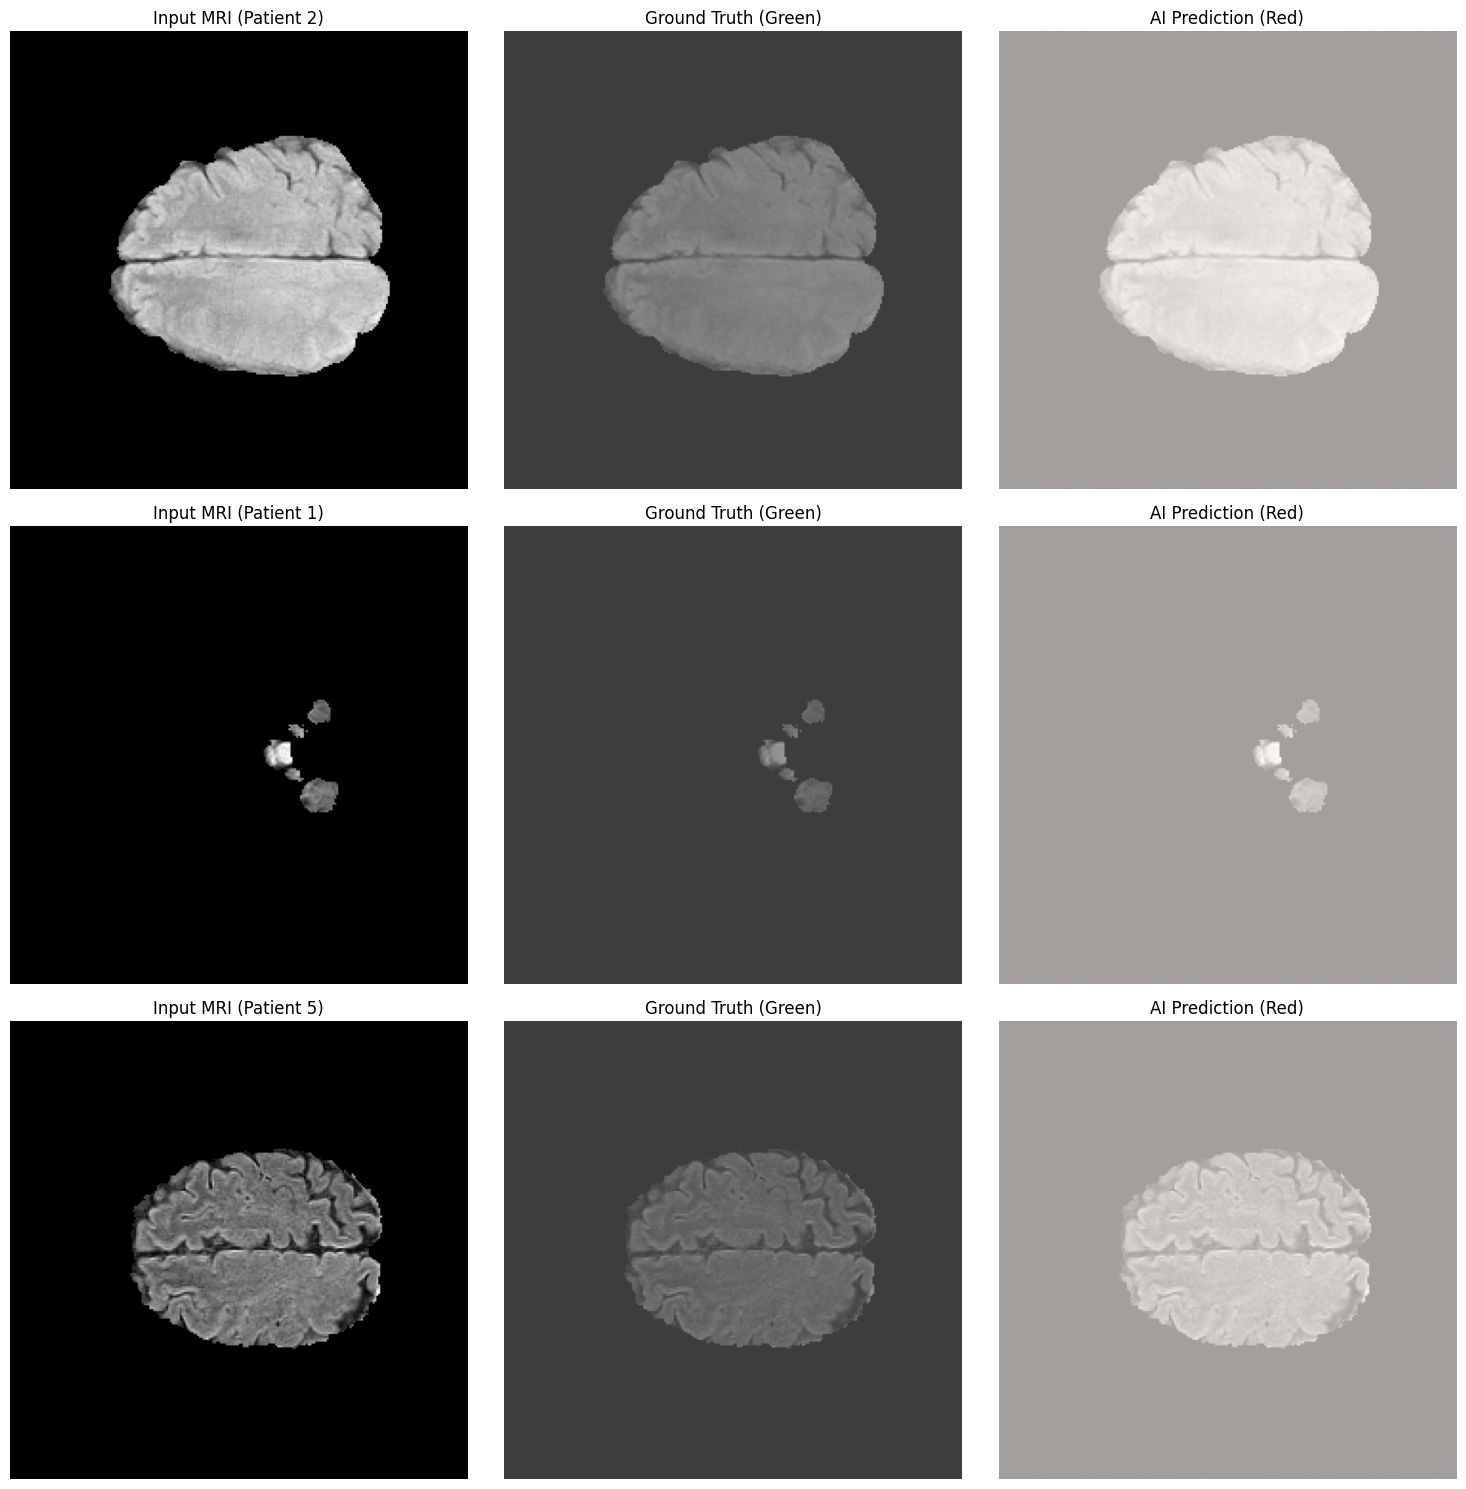

In [ ]:

import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader


val_loader = DataLoader(
    val_ds, 
    batch_size=8,         
    shuffle=True, 
    num_workers=0,        
    pin_memory=True
)

model.load_state_dict(torch.load("best_model_unet.pth"))
model.eval()

data_iter = iter(val_loader)
batch = next(data_iter)

images, labels = batch["image"].to(device), batch["label"].to(device)


with torch.no_grad():
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()


num_samples = min(3, len(images))
indices = np.random.choice(len(images), num_samples, replace=False)

plt.figure(figsize=(15, 5 * num_samples))

for i, idx in enumerate(indices):
    
    img_np = images[idx, 0, :, :].cpu().numpy()       
    lbl_np = labels[idx, 0, :, :].cpu().numpy()       
    pred_np = preds[idx, 0, :, :].cpu().numpy()       

    # Plot Input
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Input MRI (Patient {idx})")
    plt.axis('off')

    # Plot Ground Truth
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(img_np, cmap='gray', alpha=0.6)
    plt.imshow(lbl_np, cmap='Greens', alpha=0.4) # Green = Truth
    plt.title("Ground Truth (Green)")
    plt.axis('off')

    # Plot Prediction
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(img_np, cmap='gray', alpha=0.6)
    plt.imshow(pred_np, cmap='Reds', alpha=0.4)   # Red = AI Prediction
    plt.title("AI Prediction (Red)")
    plt.axis('off')

plt.tight_layout()
plt.show()

🔍 Scanning for 9 tumor examples...


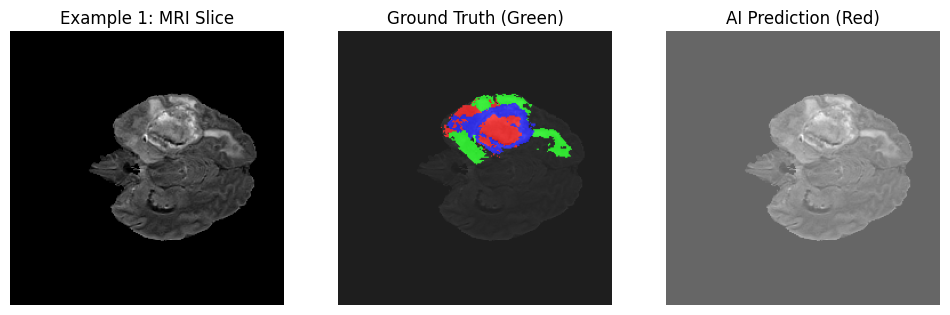

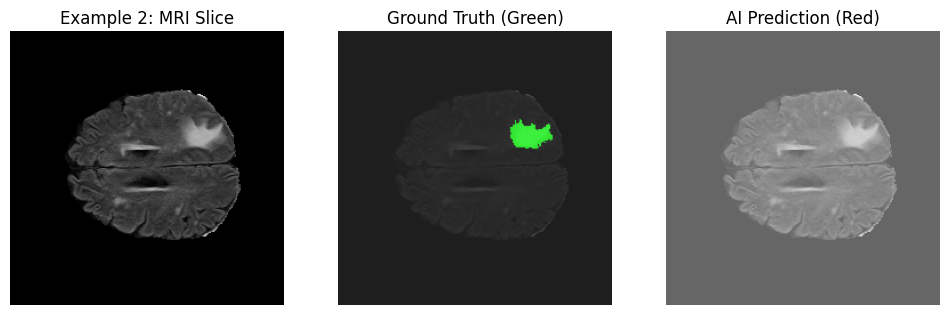

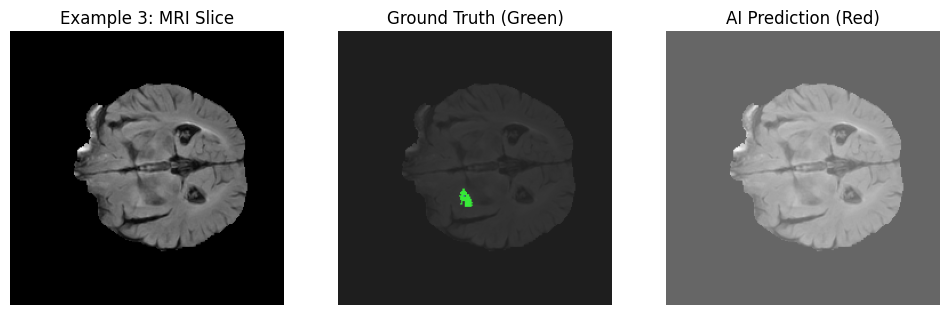

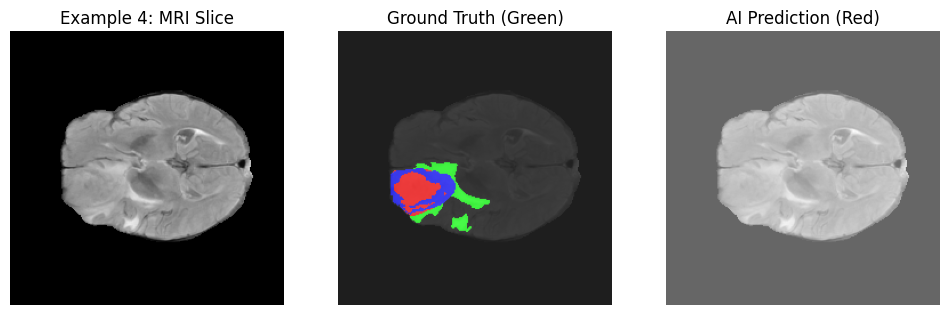

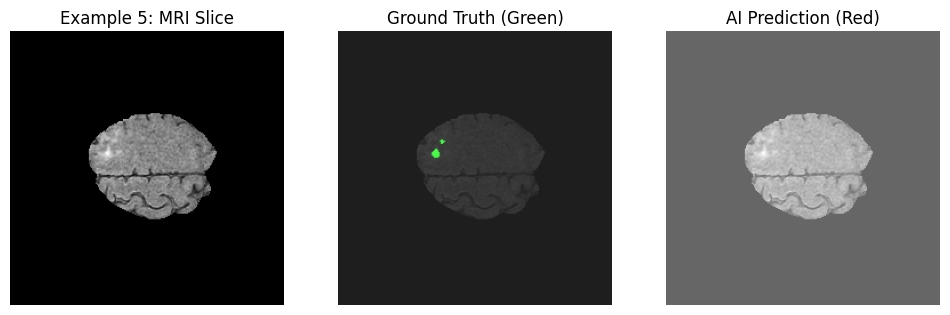

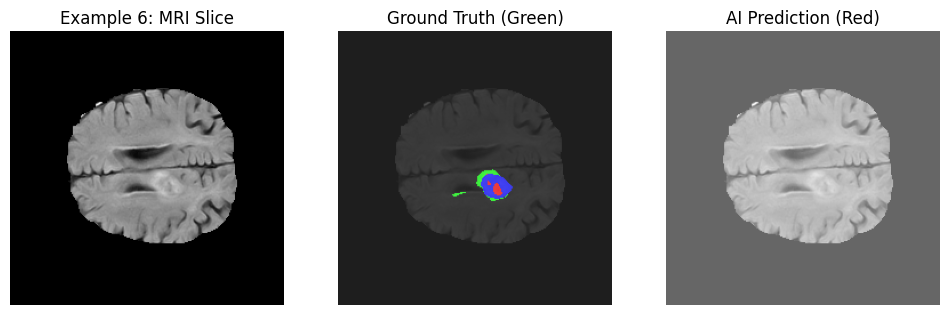

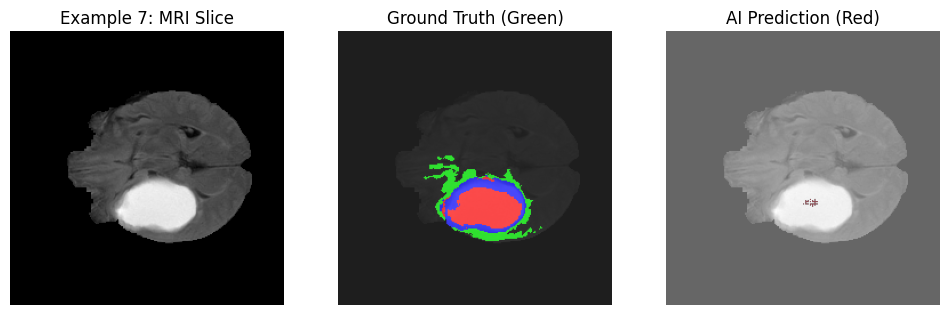

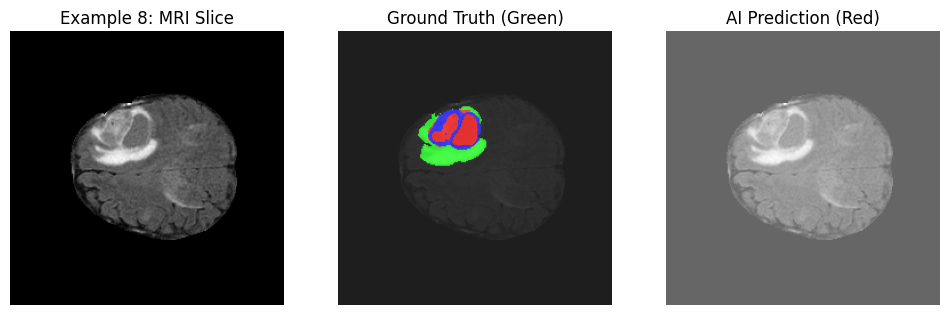

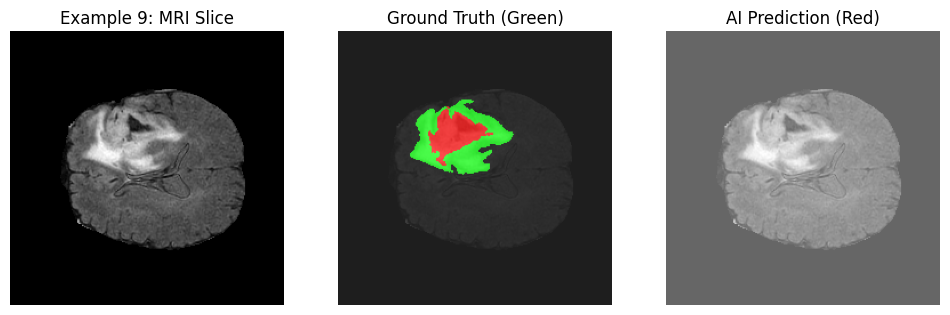

In [ ]:

import matplotlib.pyplot as plt
import torch
import numpy as np

val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0)
model 
model.eval()
tumors_found = 0
target_count = 9  
print(f"{target_count} tumor examples...")

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        
        if torch.sum(labels) > 0:
            tumors_found += 1
            
           
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
           
            img_np = images[0, 0].cpu().numpy()
            lbl_np = labels[0, 0].cpu().numpy()
            pred_np = preds[0, 0].cpu().numpy()
            
           
            plt.figure(figsize=(12, 4))
            
            # 1. Input
            plt.subplot(1, 3, 1)
            plt.imshow(img_np, cmap='gray')
            plt.title(f"Example {tumors_found}: MRI Slice")
            plt.axis('off')
            
            # 2. Ground Truth (Green)
            plt.subplot(1, 3, 2)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_lbl = np.ma.masked_where(lbl_np == 0, lbl_np)
            plt.imshow(masked_lbl, cmap='Greens', alpha=0.7, vmin=0, vmax=1)
            plt.title("Ground Truth (Green)")
            plt.axis('off')
            
            # 3. AI Prediction (Red)
            plt.subplot(1, 3, 3)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_pred = np.ma.masked_where(pred_np == 0, pred_np)
            plt.imshow(masked_pred, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
            plt.title("AI Prediction (Red)")
            plt.axis('off')
            
            plt.show()
            
            
            if tumors_found >= target_count:
                break

if tumors_found == 0:
    print("❌ Found no tumors in the validation set.")

📊 Statistics for this slice:
   - Max Confidence: 0.0000 (Needs > 0.5 to show red)
   - Min Confidence: 0.0000


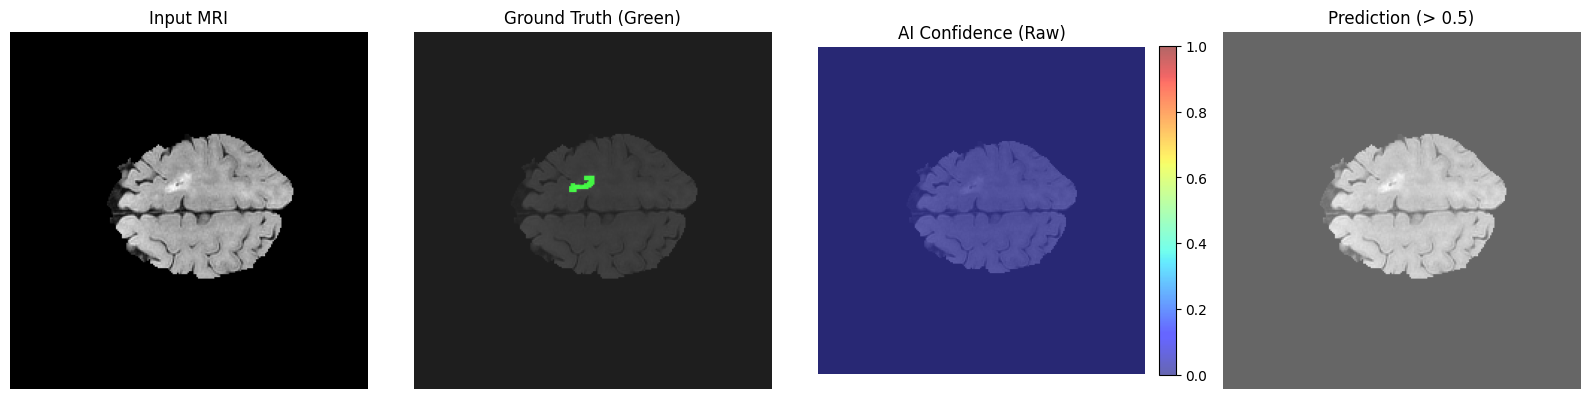

In [41]:
# %% [markdown]
# # 🔬 Deep Diagnosis: Raw Probability Heatmaps

# %%
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Setup Loader (Single Process)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0)

model.eval()
found_interesting_case = False


with torch.no_grad():
    for batch in val_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        
        # Only look at slices that ACTUALLY have a tumor
        if torch.sum(labels) > 0:
            
            # Run Inference
            logits = model(images)              # Raw output from U-Net
            probs = torch.sigmoid(logits)       # Convert to Probability (0.0 to 1.0)
            
            # Check statistics
            max_val = probs.max().item()
            min_val = probs.min().item()
            
            # Prepare for plotting
            img_np = images[0, 0].cpu().numpy()
            lbl_np = labels[0, 0].cpu().numpy()
            prob_np = probs[0, 0].cpu().numpy()
            
            print(f"📊 Statistics for this slice:")
            print(f"   - Max Confidence: {max_val:.4f} (Needs > 0.5 to show red)")
            print(f"   - Min Confidence: {min_val:.4f}")
            
            # PLOT IT
            plt.figure(figsize=(16, 5))
            
            # 1. Input MRI
            plt.subplot(1, 4, 1)
            plt.imshow(img_np, cmap='gray')
            plt.title("Input MRI")
            plt.axis('off')
            
            # 2. Ground Truth (Green)
            plt.subplot(1, 4, 2)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_lbl = np.ma.masked_where(lbl_np == 0, lbl_np)
            plt.imshow(masked_lbl, cmap='Greens', alpha=0.7, vmin=0, vmax=1)
            plt.title("Ground Truth (Green)")
            plt.axis('off')
            
            # 3. AI Confidence (Heatmap) <--- THIS IS NEW
            plt.subplot(1, 4, 3)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            # Show probabilities using 'jet' colormap (Blue=Low, Red=High)
            im = plt.imshow(prob_np, cmap='jet', alpha=0.6, vmin=0, vmax=1)
            plt.title("AI Confidence (Raw)")
            plt.axis('off')
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
            # 4. Final Prediction (Thresholded)
            plt.subplot(1, 4, 4)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            # Try a lower threshold (e.g., 0.1) just to see if anything is there
            pred_mask = (prob_np > 0.5).astype(float)
            masked_pred = np.ma.masked_where(pred_mask == 0, pred_mask)
            plt.imshow(masked_pred, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
            plt.title("Prediction (> 0.5)")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Stop after 1 example
            found_interesting_case = True
            break

if not found_interesting_case:
    print("❌ Could not find any slices with tumors.")

In [ ]:

from monai.networks.nets import SwinUNETR
from monai.transforms import Resize, NormalizeIntensity, EnsureType

SWIN_BATCH_SIZE = 24      
SWIN_IMG_SIZE = (256, 256) 
LR_SWIN = 1e-4
swin_transforms = Compose([
    NormalizeIntensity(nonzero=True, channel_wise=True),
    Resize(spatial_size=SWIN_IMG_SIZE, mode="bilinear"), # Resize Image
    EnsureType()
])


class BraTS2DSwinDataset(Dataset):
    def __init__(self, dataframe, img_size=(256, 256)):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_size = img_size
        self.resize_img = Resize(img_size, mode="bilinear")
        self.resize_lbl = Resize(img_size, mode="nearest") 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['local_path']
        try:
            with h5py.File(file_path, 'r') as f:
                img = f['image'][:] 
                mask = f['mask'][:]
        except:
            return self.__getitem__((idx + 1) % len(self.dataframe))

        if img.ndim == 3 and img.shape[-1] == 4: img = np.transpose(img, (2, 0, 1))
        if mask.ndim == 3: mask = mask[:, :, 0]
            
        wt = (mask > 0).astype(np.float32)
        label = wt[None, :, :] 
        img = img.astype(np.float32)


        img = self.resize_img(img)
        label = self.resize_lbl(label)
        
        scaler = ScaleIntensity()
        img = scaler(img)

        return {"image": img, "label": label}

# Create Swin Loaders
train_ds_swin = BraTS2DSwinDataset(train_df, img_size=SWIN_IMG_SIZE)
val_ds_swin = BraTS2DSwinDataset(val_df, img_size=SWIN_IMG_SIZE)

train_loader_swin = DataLoader(train_ds_swin, batch_size=SWIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader_swin = DataLoader(val_ds_swin, batch_size=SWIN_BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print("✅ Swin Data Loaders Ready (256x256).")

NameError: name 'Compose' is not defined

In [48]:
# %%
from monai.networks.nets import SwinUNETR
import torch.optim as optim
from monai.losses import DiceLoss
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SWIN_IMG_SIZE = (256, 256)
LR_SWIN = 1e-4


model2 = SwinUNETR(
    in_channels=4,
    out_channels=1,
    feature_size=24,         
    use_checkpoint=True,     
    spatial_dims=2           
).to(device)

# 2. Setup Optimizer & Loss
optimizer2 = optim.AdamW(model2.parameters(), lr=LR_SWIN, weight_decay=1e-5)
loss_function = DiceLoss(sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5)
scaler = torch.amp.GradScaler('cuda')

# Checkpoints for Model 2
CHECKPOINT_SWIN = "checkpoint_swin.pth"
BEST_MODEL_SWIN = "best_model_swin.pth"


In [23]:
MAX_EPOCHS=20


In [ ]:
best_metric_swin = 1.0

LR_SWIN = 2e-5   
MAX_EPOCHS = 20

# Re-init optimizer with new LR
optimizer2 = optim.AdamW(model2.parameters(), lr=LR_SWIN, weight_decay=1e-5)


for epoch in range(MAX_EPOCHS):
    model2.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader_swin, desc=f"Swin Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        if batch_data is None: continue
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer2.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model2(inputs)
            loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer2)
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        
        scaler.step(optimizer2)
        scaler.update()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / step
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")
    
    if avg_loss < best_metric_swin:
        best_metric_swin = avg_loss
        torch.save(model2.state_dict(), BEST_MODEL_SWIN)
        print(f"💎 New Best Swin Model Saved! ({best_metric_swin:.4f})")

🚀 Restarting Swin Training with Gradient Clipping...


Swin Epoch 1/20: 100%|██████████| 445/445 [05:00<00:00,  1.48batch/s, loss=1.0000]


Epoch 1 Avg Loss: 0.9852
💎 New Best Swin Model Saved! (0.9852)


Swin Epoch 2/20: 100%|██████████| 445/445 [04:34<00:00,  1.62batch/s, loss=0.9979]


Epoch 2 Avg Loss: 0.9791
💎 New Best Swin Model Saved! (0.9791)


Swin Epoch 3/20: 100%|██████████| 445/445 [04:36<00:00,  1.61batch/s, loss=1.0000]


Epoch 3 Avg Loss: 0.9740
💎 New Best Swin Model Saved! (0.9740)


Swin Epoch 4/20:   6%|▌         | 25/445 [00:15<04:26,  1.58batch/s, loss=0.9658]


KeyboardInterrupt: 

In [ ]:

import torch.optim as optim
from monai.networks.nets import UNet
from monai.losses import DiceCELoss # <--- The Upgrade
from monai.transforms import NormalizeIntensity, EnsureType, Compose
from torch.utils.data import DataLoader


class BraTS2DDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['local_path']
        try:
            with h5py.File(file_path, 'r') as f:
                img = f['image'][:] 
                mask = f['mask'][:]
        except:
            return self.__getitem__((idx + 1) % len(self.dataframe))

        if img.ndim == 3 and img.shape[-1] == 4: img = np.transpose(img, (2, 0, 1))
        if mask.ndim == 3: mask = mask[:, :, 0]
            
        wt = (mask > 0).astype(np.float32)
        label = wt[None, :, :] 
        img = img.astype(np.float32)

        if self.transform: img = self.transform(img)
        return {"image": img, "label": label}

train_transforms = Compose([NormalizeIntensity(nonzero=True, channel_wise=True), EnsureType()])
train_ds = BraTS2DDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)


model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


loss_function = DiceCELoss(sigmoid=True, squared_pred=True, smooth_nr=1e-5, smooth_dr=1e-5)

optimizer = optim.Adam(model.parameters(), lr=1e-4) 

best_metric = 1.0



In [34]:
MAX_EPOCHS = 10

In [35]:
for epoch in range(MAX_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCHS}", unit="batch")
    
    for batch_data in progress_bar:
        if batch_data is None: continue
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / step
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")
    
    if avg_loss < best_metric:
        best_metric = avg_loss
        torch.save(model.state_dict(), "best_model_final.pth")
        print(f"💾 Saved Best Model ({best_metric:.4f})")


Epoch 1/10: 100%|██████████| 167/167 [03:41<00:00,  1.33s/batch, loss=0.6679]


Epoch 1 Avg Loss: 0.7679
💾 Saved Best Model (0.7679)


Epoch 2/10: 100%|██████████| 167/167 [03:11<00:00,  1.15s/batch, loss=0.8349]


Epoch 2 Avg Loss: 0.7631
💾 Saved Best Model (0.7631)


Epoch 3/10: 100%|██████████| 167/167 [03:07<00:00,  1.12s/batch, loss=0.8408]


Epoch 3 Avg Loss: 0.7584
💾 Saved Best Model (0.7584)


Epoch 4/10: 100%|██████████| 167/167 [05:10<00:00,  1.86s/batch, loss=0.7732]


Epoch 4 Avg Loss: 0.7542
💾 Saved Best Model (0.7542)


Epoch 5/10: 100%|██████████| 167/167 [03:22<00:00,  1.21s/batch, loss=0.7863]


Epoch 5 Avg Loss: 0.7500
💾 Saved Best Model (0.7500)


Epoch 6/10: 100%|██████████| 167/167 [02:19<00:00,  1.20batch/s, loss=0.8021]


Epoch 6 Avg Loss: 0.7458
💾 Saved Best Model (0.7458)


Epoch 7/10: 100%|██████████| 167/167 [02:24<00:00,  1.16batch/s, loss=0.7697]


Epoch 7 Avg Loss: 0.7423
💾 Saved Best Model (0.7423)


Epoch 8/10: 100%|██████████| 167/167 [02:28<00:00,  1.13batch/s, loss=0.7022]


Epoch 8 Avg Loss: 0.7390
💾 Saved Best Model (0.7390)


Epoch 9/10: 100%|██████████| 167/167 [02:30<00:00,  1.11batch/s, loss=0.6731]


Epoch 9 Avg Loss: 0.7354
💾 Saved Best Model (0.7354)


Epoch 10/10: 100%|██████████| 167/167 [02:28<00:00,  1.13batch/s, loss=0.7593]

Epoch 10 Avg Loss: 0.7329
💾 Saved Best Model (0.7329)


In [14]:
model.load_state_dict(torch.load("best_model_final.pth"))

<All keys matched successfully>

✅ Loaded model weights from: best_model_final.pth
🔍 Scanning validation set for a tumor slice...


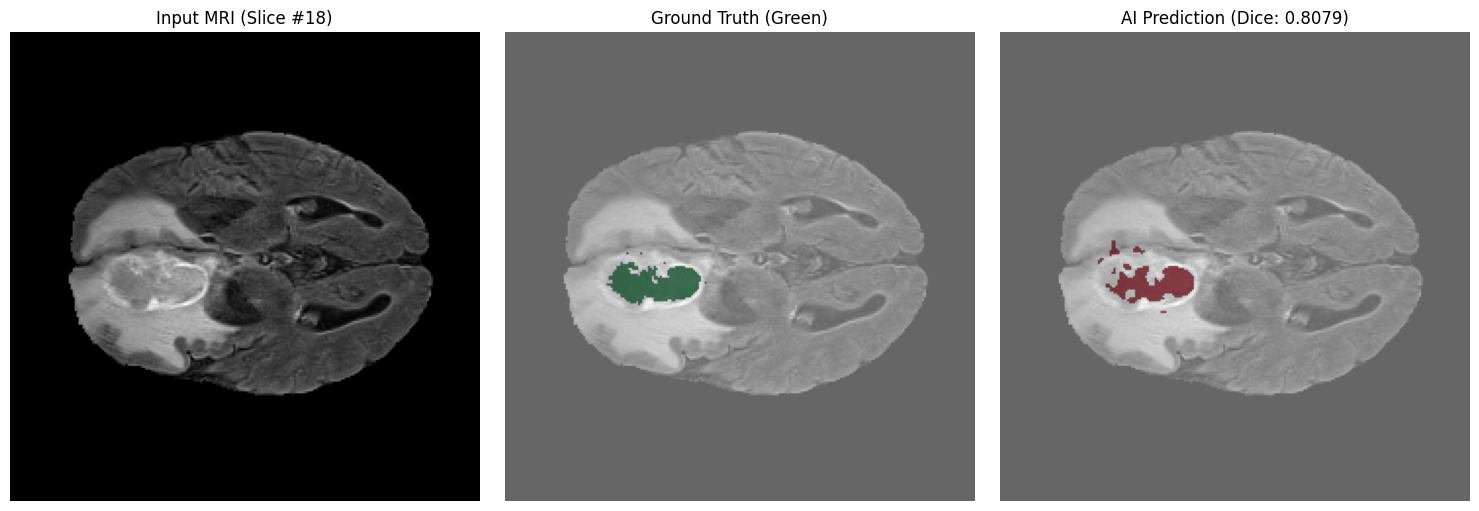

🎉 Visualization Complete!


In [ ]:

import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import h5py  # Added missing import
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from monai.networks.nets import UNet
from monai.transforms import Compose, NormalizeIntensity, EnsureType 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_model_final.pth" 

DATA_DIR = r"C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data"
META_FILE = r"C:\Users\shara\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3\BraTS2020_training_data\content\data\meta_data.csv"

if 'val_df' not in locals():
    try:
        df = pd.read_csv(META_FILE)
        df['filename'] = df['slice_path'].apply(lambda x: os.path.basename(x))
        df['local_path'] = df['filename'].apply(lambda x: os.path.join(DATA_DIR, x))
        val_df = df.sample(n=200, random_state=42).reset_index(drop=True)
        print("⚠️ 'val_df' not found. Loaded a sample from meta_data.csv for visualization.")
    except Exception as e:
        print(f"❌ Could not load meta_data.csv: {e}")
        val_df = pd.DataFrame(columns=['local_path'])

class BraTSVisDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transforms = Compose([NormalizeIntensity(nonzero=True, channel_wise=True), EnsureType()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if idx >= len(self.dataframe): return None
        
        row = self.dataframe.iloc[idx]
        file_path = row['local_path']
        
        try:
            with h5py.File(file_path, 'r') as f:
                img = f['image'][:] 
                mask = f['mask'][:]
        except:
            return None 

        if img.ndim == 3 and img.shape[-1] == 4: img = np.transpose(img, (2, 0, 1))
        if mask.ndim == 3: mask = mask[:, :, 0]
            
        wt = (mask > 0).astype(np.float32)
        label = wt[None, :, :] 
        img = img.astype(np.float32)

        img = self.transforms(img)
        return {"image": img, "label": label}


val_ds_vis = BraTSVisDataset(val_df)
val_loader = DataLoader(val_ds_vis, batch_size=1, shuffle=True, num_workers=0) # num_workers=0 for Windows

model = UNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


model.load_state_dict(torch.load(MODEL_PATH))

model.eval()

found = False
attempts = 0
max_attempts = 200 

with torch.no_grad():
    for batch in val_loader:
        if batch is None: continue # Skip failed loads
        
        attempts += 1
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        
        # Check if this slice actually has a tumor (Sum of pixels > 0)
        if torch.sum(labels) > 0:
            # Run Inference
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate Dice Score
            intersection = (preds * labels).sum()
            union = preds.sum() + labels.sum()
            dice_score = (2. * intersection) / (union + 1e-5)
            
            # Prepare for Plotting
            img_np = images[0, 0].cpu().numpy()     # Channel 0 (FLAIR)
            lbl_np = labels[0, 0].cpu().numpy()     # Truth
            pred_np = preds[0, 0].cpu().numpy()     # Prediction
            
            # --- PLOTTING ---
            plt.figure(figsize=(15, 5))
            
            # 1. Input MRI
            plt.subplot(1, 3, 1)
            plt.imshow(img_np, cmap='gray')
            plt.title(f"Input MRI (Slice #{attempts})")
            plt.axis('off')
            
            # 2. Ground Truth (Green)
            plt.subplot(1, 3, 2)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_lbl = np.ma.masked_where(lbl_np == 0, lbl_np)
            plt.imshow(masked_lbl, cmap='Greens', alpha=0.7, vmin=0, vmax=1)
            plt.title("Ground Truth (Green)")
            plt.axis('off')
            
            # 3. AI Prediction (Red)
            plt.subplot(1, 3, 3)
            plt.imshow(img_np, cmap='gray', alpha=0.6)
            masked_pred = np.ma.masked_where(pred_np == 0, pred_np)
            plt.imshow(masked_pred, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
            plt.title(f"AI Prediction (Dice: {dice_score:.4f})")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            found = True
            break 
        
        if attempts >= max_attempts:
            print(f"⚠️ Scanned {max_attempts} slices but found no tumors.")
            break

if found:
    print("Visualization Complete")